In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import os
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(os.listdir('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'))

['dataset', 'test', 'train']


In [3]:
SIZE = 128

In [4]:
train_images = []
train_labels = [] 
for directory_path in glob.glob("/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
#         print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

rottenbanana
freshoranges
rottenoranges
freshbanana
rottenapples
freshapples


In [5]:
# test
test_images = []
test_labels = [] 
for directory_path in glob.glob("/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/*"):
    fruit_label = directory_path.split("/")[-1]
    print(fruit_label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

rottenbanana
freshoranges
rottenoranges
freshbanana
rottenapples
freshapples


In [6]:
# Save the preprocessed images as a NumPy array
np.save("/kaggle/working/train_images.npy", train_images)

# Save the labels as a CSV file
df = pd.DataFrame({"label": train_labels})
df.to_csv("/kaggle/working/train_labels.csv", index=False)


# Save the preprocessed images as a NumPy array
np.save("/kaggle/working/test_images.npy", test_images)

# Save the labels as a CSV file
df = pd.DataFrame({"label": train_labels})
df.to_csv("/kaggle/working/test_labels.csv", index=False)

In [7]:
# Load the processed images and labels from the Kaggle dataset
train_images = np.load("/kaggle/working/train_images.npy")
train_labels = pd.read_csv("/kaggle/working/train_labels.csv")["label"].values

test_images = np.load("/kaggle/working/test_images.npy")
test_labels = pd.read_csv("/kaggle/working/test_labels.csv")["label"].values

In [8]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the mapping
print(class_mapping)

{'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


In [9]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
# x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [10]:
activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation,input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D(pool_size=3))

feature_extractor.add(Conv2D(64, 3, activation = activation))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D(pool_size=3))

feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(512, activation = activation)(x)
prediction_layer = Dense(6, activation = 'softmax')(x)

In [11]:
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 32)       0     

In [12]:
# feature_extractor.save("feature_extractor_model.h5")

In [13]:
# import joblib
# joblib.dump(le, "label_encoder.pkl")
# # 

In [15]:
#Now, let us use features from convolutional network for RF
X_for_RF = feature_extractor.predict(x_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

341/341 [==============================] - 1s 3ms/step


RandomForestClassifier(n_estimators=50, random_state=42)

In [16]:
#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

341/341 [==============================] - 1s 3ms/step


In [17]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  1.0


<Axes: >

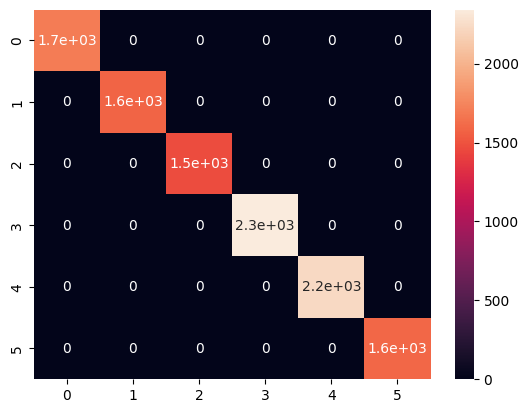

In [18]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [19]:
from sklearn.metrics import classification_report

In [20]:
# y_pred = RF_model.predict(x_test)[]
# print(classification_report(y_test,y_pred,labels = np.unique(y_pred)))

1/1 [==============================] - 0s 73ms/step
The prediction for this image is:  ['rottenbanana']
The actual label for this image is:  rottenbanana


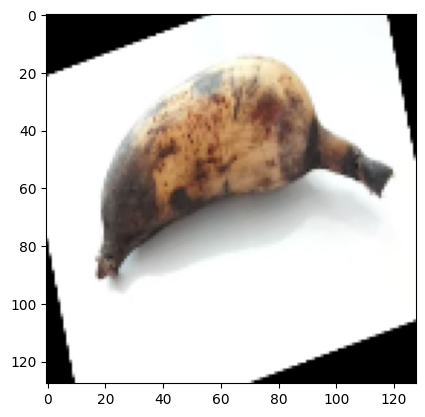

In [21]:
#Check results on a few select images
#n=5 #dog park. RF works better than CNN
# for n in range(0,10900,50):
n=1000#Select the index of image to be loaded for testing
img = x_test[n]
#     plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])
plt.imshow(img)

In [22]:
# # save the model to disk
# import pickle
# filename = 'finalized_RF2_model.pkl'
# pickle.dump(RF_model, open(filename, 'wb'))